In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate
import pymssql
import pickle
import os


import warnings
warnings.filterwarnings('ignore')


server='40.123.229.239'
username='smartae'
password = os.getenv('SQL_PASSWORD')
database='master'

conn = pymssql.connect(server, username, password, "master")
cursor = conn.cursor(as_dict=True)

m1='XGB_hr_a5'
m2='XGB_hr_a1'
with open(f'models/{m1}.pkl','rb') as f:
    XGB1=pickle.load(f)
with open(f'models/{m2}.pkl','rb') as f:
    XGB2=pickle.load(f)

KeyboardInterrupt: 

In [ ]:
df=pd.read_csv('../SQLMasterMetaData2.csv').drop(['Unnamed: 0'],axis=1)
df[df['TABLE_NAME'].str.contains('R320')].TABLE_NAME.values

parameters={'amb_temp1': 'R320_2_CH1_AMB_TEMP','amb_temp4': 'R320_2_CH4_AMB_TEMP', 'vsd_freq': 'R320_2_CH1_VSD_OUTFREQ',
          'ch1_total_kW': 'R320_2_CH1_METER_TOTAL_ACTIVE_POWER',
          'ch2_kW1': 'R320_2_CH2A_METER_Total_Active_power', 'ch2_kW2': 'R320_2_CH2B_METER_Total_Active_power',
          'ch3_kW1': 'R320_2_CH3A_METER_Total_Active_power', 'ch3_kW2': 'R320_2_CH3B_METER_Total_Active_power',
          'pp1': 'R320_1_PP1_FB', 'pp2': 'R320_1_PP2_FB', 'pp3': 'R320_1_PP3_FB', 'pp4': 'R320_1_PP4_FB',
          'pp5': 'R320_1_PP5_FB', 'pp6': 'R320_1_PP6_FB', 'pp7': 'R320_1_PP7_FB', 'pp8': 'R320_1_PP8_FB',
          'sup_temp': 'R320_2_CH4_SUP_WTRTEMP', 'ret_temp': 'R320_2_CH4_RET_WTRTEMP', 'total_kW': 'R320_2_CH4_METER_TOTAL_ACTIVE_POWER',
          }

ch_parms=list(parameters.values())
labels=list(parameters.keys())

In [ ]:
ignored=[]
res=pd.DataFrame()
for i,point in enumerate(ch_parms[:]):
        
        # point=rtus[3]
        query1=f"""SELECT 
                Timestamp,[VALUE] as {labels[i]}
                FROM [niagara].[dbo].{point}
                where timestamp < '2023-09-01'"""
        # print(query1)
        # cursor.execute(query1)
        # tempdf=pd.DataFrame(cursor.fetchall())
        tempdf=pd.read_sql(query1,conn)
        if len(tempdf)<10000:
            print(point,'==> IGNORED!!!')
            ignored.append(point)
            continue
        tempdf=tempdf.groupby(pd.Grouper(key='Timestamp',freq='15min')).mean().round(2).dropna()
        res=res.join(tempdf,how='outer')
res.head()

,amb_temp1,amb_temp4,vsd_freq,ch1_total_kW,ch2_kW1,ch2_kW2,ch3_kW1,ch3_kW2,pp1,pp2,pp3,pp4,pp5,pp6,pp7,pp8,sup_temp,ret_temp,total_kW
Timestamp,,,,,,,,,,,,,,,,,,,
2019-09-17 15:30:00,37.44,NaN,137.3,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0,100.0,100.0,0.11,0.59,100.0,NaN,NaN,NaN
2019-09-17 15:45:00,37.39,36.78,137.3,0.14,0.68,0.66,0.68,0.0,100.0,100.0,100.0,100.0,100.0,0.10,0.60,100.0,6.17,10.33,0.12
2019-09-17 16:00:00,36.89,36.44,137.3,0.14,0.68,0.66,0.68,0.0,100.0,100.0,100.0,100.0,100.0,0.12,0.61,100.0,6.22,10.33,0.12
2019-09-17 16:15:00,36.28,36.17,140.0,0.14,0.68,0.66,0.68,0.0,100.0,100.0,100.0,100.0,100.0,0.12,0.62,100.0,6.28,10.44,0.12
2019-09-17 16:30:00,36.33,35.89,139.7,0.14,0.68,0.66,0.68,0.0,100.0,100.0,100.0,100.0,100.0,0.10,0.59,100.0,6.22,10.39,0.12


In [ ]:
d1=res.copy()
d1=d1[~d1['total_kW'].isna()]

temp=pd.read_pickle('ambtemp.pkl')
temp.index=pd.to_datetime(temp.index)

d1['amb_temp']=temp


d1['ch2kw']=d1.ch2_kW1+d1.ch2_kW2
d1['ch3kw']=d1.ch3_kW1+d1.ch3_kW2
d1['ch1_run_sts']=d1.ch1_total_kW.apply(lambda x: 1 if x>10 else 0)
d1['ch2_run_sts']=d1.ch2kw.apply(lambda x: 1 if x>10 else 0)
d1['ch3_run_sts']=d1.ch3kw.apply(lambda x: 1 if x>10 else 0)
d1['ch4_run_sts']=d1.total_kW.apply(lambda x: 1 if x>10 else 0)
d1['NR_ch']=d1.ch1_run_sts+d1.ch2_run_sts+d1.ch3_run_sts+d1.ch4_run_sts
d1['fper_ch']=d1.apply(lambda x: 0 if x.NR_ch==0 else (x.pp1+x.pp2+x.pp3+x.pp4+x.pp5+x.pp6+x.pp7+x.pp8)/x.NR_ch,axis=1)
d1=d1[~d1.fper_ch.isna()]
d1['dT']=d1.apply(lambda x: max(0,x.ret_temp-x.sup_temp),axis=1)


(15.0, 50.0)

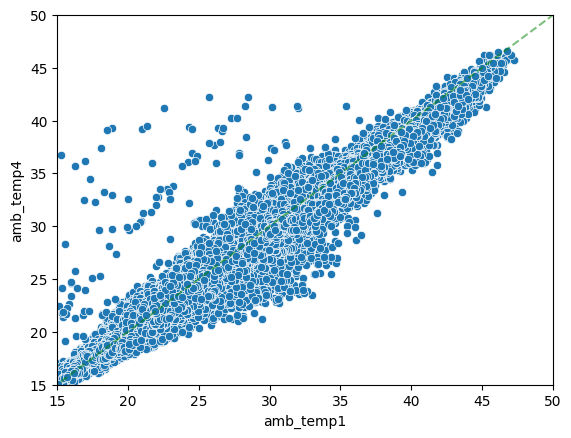

In [ ]:
d2=d1.copy()
d2=d2[(d2.amb_temp4>15)&(d2.amb_temp4<50)]
d2=d2[(d2.amb_temp1>15)&(d2.amb_temp1<50)]
ax1=sns.scatterplot(x=d2.amb_temp1,y=d2.amb_temp4)
sns.lineplot(x=[-10, 100], y=[-10, 100], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax1)
ax1.set_xlim([15,50])
ax1.set_ylim([15,50])
# d2

### Main Changes

<AxesSubplot: xlabel='cload_%', ylabel='Count'>

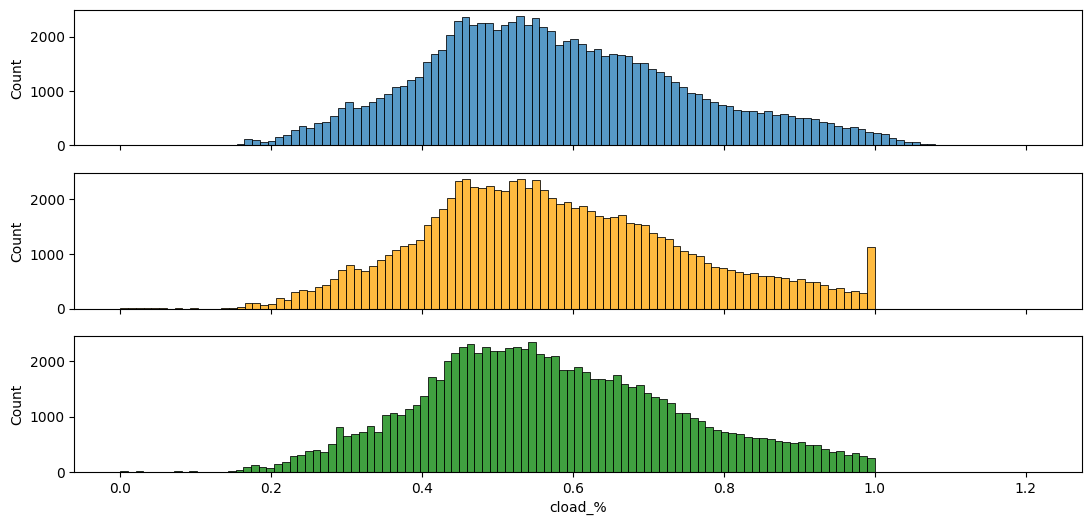

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=[13,6],sharex=True)
# ax.set_xticklabels(ax.get_xticklabels())
dd=d2.copy()
# sometimes there are 6 pumps running for a single chiller !!!
dd['cload']=dd.apply(lambda x: x.fper_ch*x.dT,axis=1)
max_fper_ch=200
dd['full_cload']=max_fper_ch * 5 # 2 pumps running with dT of 5 °C
# dd['full_cload']=300 * 5 # 3 pumps running with dT of 5 °C

# cload      = flow      * cp * dT
# full_cload = max_flow  * cp * max_dT = 300 * cp * 5
dd=dd[dd.fper_ch<=max_fper_ch]
dd['cload_%']=dd.apply(lambda x: x.cload/x.full_cload,axis=1)
dd['cload_%_']=dd.apply(lambda x: min(1,x.cload/x.full_cload),axis=1)

# dd=dd[(dd.sup_temp>=5)&(dd.sup_temp<=11)] # only care when it is running and sup temp is valid
# dd=dd[(dd.ret_temp>=8)&(dd.ret_temp<=15)] # only care when it is running and ret temp is valid

dd=dd[(dd.sup_temp>=6)&(dd.sup_temp<=10)] # only care when it is running and sup temp is valid
dd=dd[(dd.ret_temp>=9)&(dd.ret_temp<=14)] # only care when it is running and ret temp is valid
dd=dd[(dd.ch4_run_sts==1)&(dd.dT>0)] # only care when it is running and dT is real
# dd=dd[dd['cload_%']<=1.00] # remove outliers 
sns.histplot(dd['cload_%'],ax=ax1)
sns.histplot(dd['cload_%_'],color='orange',ax=ax2)
sns.histplot(dd[dd['cload_%']<=1]['cload_%'],color='green',ax=ax3)


In [ ]:
dd=dd[(dd['cload_%']<=1)&(dd['cload_%']>0.3)] # non-vfd limit is 0.3 and vfd limit is 0.1, but we need to compare to non-vfd so we remove <0.3
dd2=dd.copy()
# dd2=dd2.groupby(pd.Grouper(freq='1d')).mean()
fig,ax=plt.subplots(figsize=[15,10])
# dd2.groupby(pd.Grouper(key=dd2.index, freq='1h')).mean()
sns.scatterplot(y=dd2.total_kW,x=dd2['cload_%_'],hue=dd2.amb_temp,ax=ax)

<AxesSubplot: xlabel='cload_%_', ylabel='total_kW'>

Error in callback <function flush_figures at 0x000001F927F5BBA0> (for post_execute):


KeyboardInterrupt: 

<AxesSubplot: >

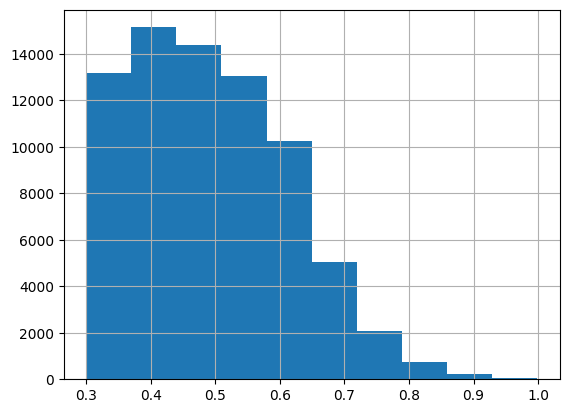

In [ ]:
old=pd.read_csv('Const_spd_screw_ch.csv')
f=interpolate.interp1d(old['capacity%'],old['power%'],fill_value='extrapolate')
max_power=max(dd.total_kW)
dd['old_max_kW']=f(dd['cload_%_'])*max_power
dd['power_%']=dd.apply(lambda x: x.total_kW/x.old_max_kW,axis=1)
dd=dd[(dd['power_%']<=1)&(dd['power_%']>0.3)]
dd['power_%'].hist()

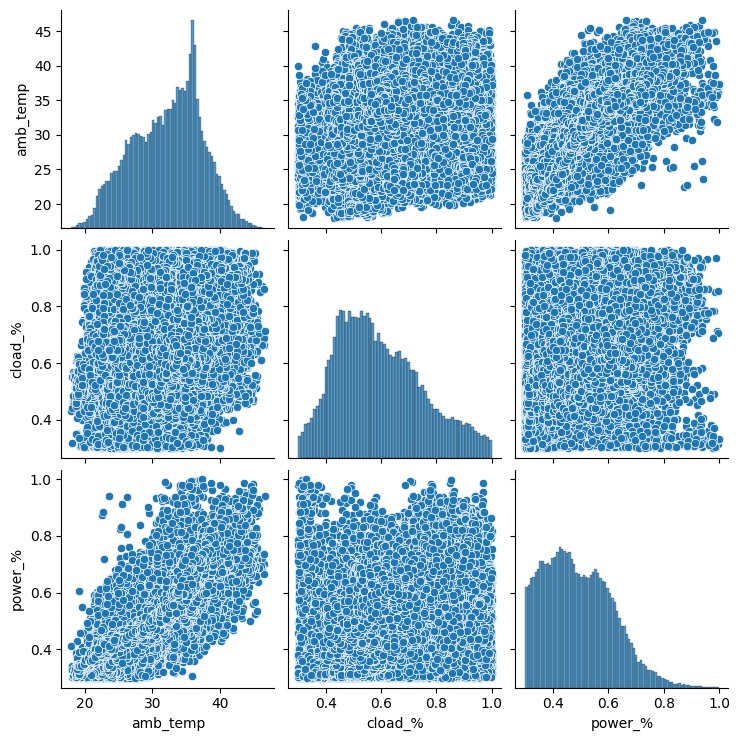

In [ ]:
r=dd.copy()
r=r[['amb_temp','cload_%','total_kW','power_%']]
sns.pairplot(r[['amb_temp','cload_%','power_%']])
# sns.histplot(r.amb_temp)

Model1
Error: 0.10811135745859736
Model2
Error: 0.09595508016606566


Text(0.5, 1.0, 'optimized model')

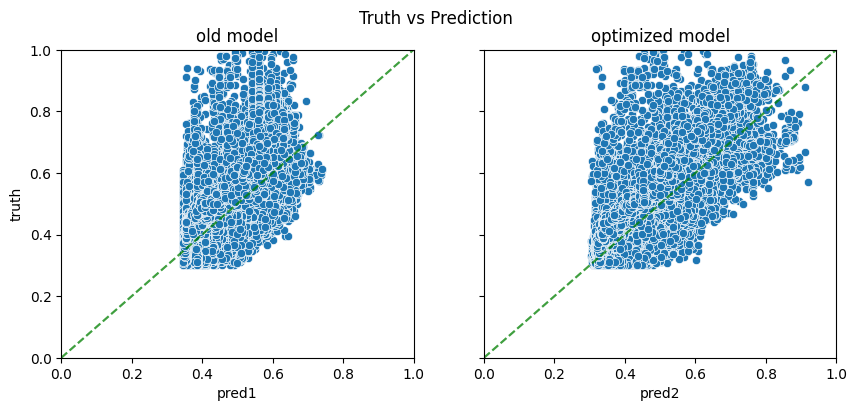

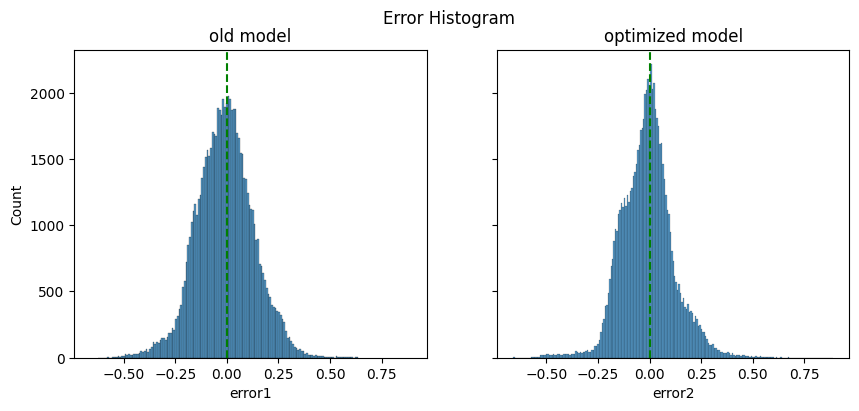

In [ ]:
model=XGB2
tt1=r.copy()

tt1['pred1']=XGB1.predict(tt1[['amb_temp', 'cload_%']])
tt1['pred2']=XGB2.predict(tt1[['amb_temp', 'cload_%']])
tt1['truth']=tt1['power_%']
tt1['error1']=tt1.apply(lambda x: (x.pred1-x.truth)/x.truth,axis=1)
tt1['error2']=tt1.apply(lambda x: (x.pred2-x.truth)/x.truth,axis=1)
print('Model1\nError:',abs(tt1.error1).mean())
print('Model2\nError:',abs(tt1.error2).mean())
# tt1
# region plot
fig,(ax1,ax2)=plt.subplots(1,2,figsize=[10,4],sharey=True,sharex=True)
sns.scatterplot(x=tt1.pred1,y=tt1.truth,ax=ax1)
sns.scatterplot(x=tt1.pred2,y=tt1.truth,ax=ax2)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax1)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax2)
plt.suptitle('Truth vs Prediction')

ax1.set_title(m1)
ax2.set_title(m2)
ax1.set_ylim([0,1])
ax1.set_xlim([0,1])

fig,(ax3,ax4)=plt.subplots(1,2,figsize=[10,4],sharey=True,sharex=True)
sns.histplot(x=tt1.error1,ax=ax3)
ax3.axvline(x=0, color='green', linestyle='--', label='0')
sns.histplot(x=tt1.error2,ax=ax4)
ax4.axvline(x=0, color='green', linestyle='--', label='0')
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax1)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax2)
plt.suptitle('Error Histogram')
# plt.axvline(x=0, color='green', linestyle='-', label='0',ax=ax4)

ax3.set_title(m1)
ax4.set_title(m2)


# endregion

### Aggregating test data over ±n hours (moving window)

In [ ]:
from datetime import timedelta
r2=r[['amb_temp','cload_%','power_%']]
# r2.loc['2019-10-03 11:45:00':'2019-10-03 15:45:00']
def ag(row,r2):
    n=2
    i=row.name
    im2=i-timedelta(hours=n)
    ip2=i+timedelta(hours=n)
    d=r2.loc[im2:ip2].mean()
    # print(d)
    return d
r3=r2.apply(lambda x:ag(x,r2),axis=1)

X_3=r3.copy()
y_3=X_3.pop('power_%')

# pipeline is meaningless, no need for imputing nor scaling
ttp=X_3.copy()
ttp['truth']=y_3
ttp['pred_XGB1']=XGB1.predict(X_3)
ttp['error_XGB1']=ttp.apply(lambda x: (x.pred_XGB1-x.truth)/x.truth,axis=1)
ttp['pred_XGB2']=XGB2.predict(X_3)
ttp['error_XGB2']=ttp.apply(lambda x: (x.pred_XGB2-x.truth)/x.truth,axis=1)
e_XGB1=np.round(abs(ttp.error_XGB1).mean(),3)
e_XGB2=np.round(abs(ttp.error_XGB2).mean(),3)
# dictt.loc[f,'XGB_Error']=e_XGB
# dictt.loc[f,'RFR_Error']=e_RFR
# print('test: ',len(X_3) ,'====>',e_XGB1,e_XGB2)
print(f'model1: {e_XGB1}\nmodel2: {e_XGB2}')

plt.figure(figsize=[15,5])
sns.lineplot(r2.loc['2019-10-03 11:45:00':'2019-11-03 15:45:00']['power_%'],label='original')
sns.lineplot(r3.loc['2019-10-03 11:45:00':'2019-11-03 15:45:00']['power_%'],label='aggrigated')

KeyboardInterrupt: 

### Ambient Temperature Analysis

Text(0.5, 1.0, 'ch4_amb_temp')

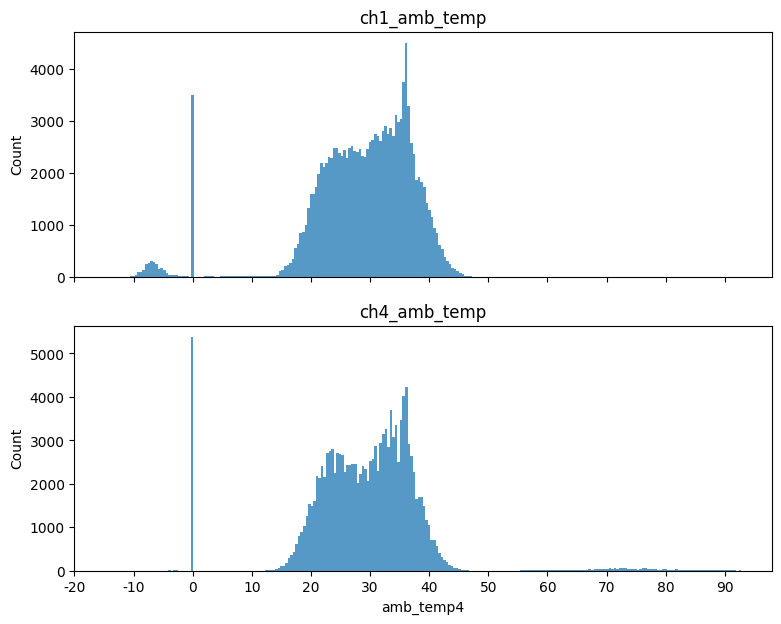

In [ ]:
t=d1.copy()
t=t[['amb_temp1', 'amb_temp4']]
fig,(ax1,ax2)=plt.subplots(2,1,figsize=[9,7],sharex=True)
sns.histplot(t.amb_temp1,ax=ax1,linewidth=0)
sns.histplot(t.amb_temp4,ax=ax2,linewidth=0)
ax1.set_xticks(np.arange(-20,100,10),rotation=45)
ax1.set_xticklabels(ax1.get_xticks(),rotation=45)
# ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
ax1.set_title('ch1_amb_temp')
ax2.set_title('ch4_amb_temp')
# ax1.set_yscale('log')

<AxesSubplot: xlabel='amb_temp1', ylabel='amb_temp4'>

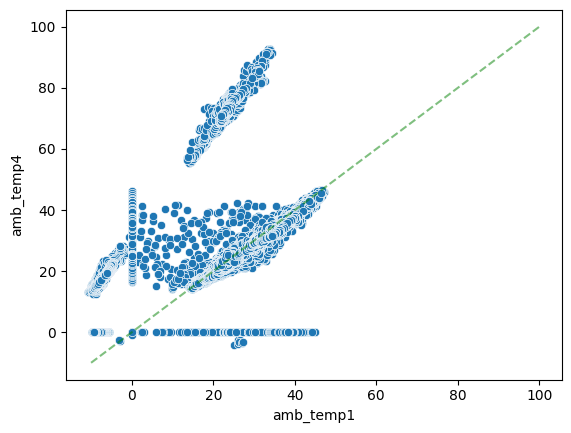

In [ ]:

# sns.scatterplot(x=t.amb_temp1,y=t.amb_temp4)
ax1=sns.scatterplot(x=t.amb_temp1,y=t.amb_temp4)
sns.lineplot(x=[-10, 100], y=[-10, 100], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax1)

# t

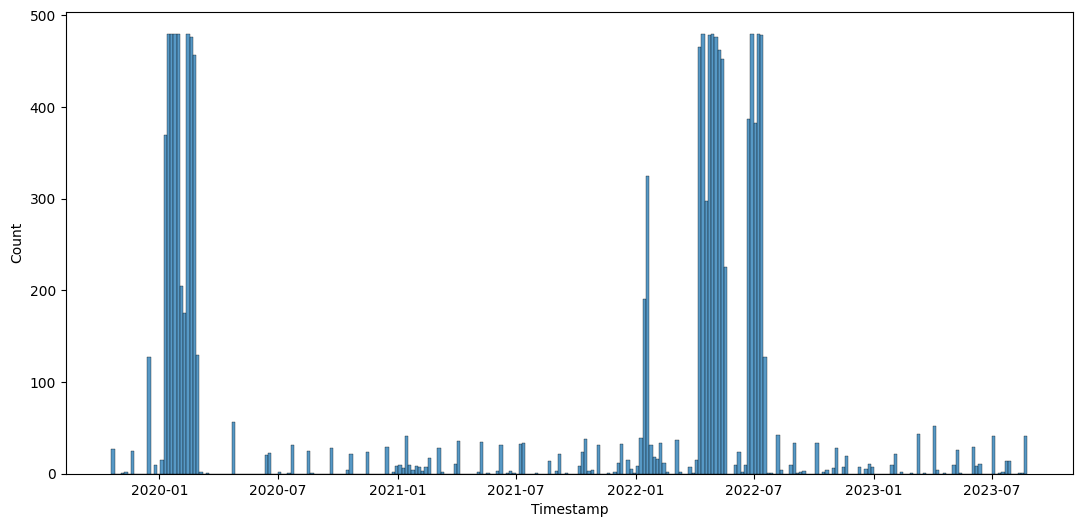

In [ ]:
plt.figure(figsize=[13,6])
ax=sns.histplot(t[abs(t.amb_temp1-t.amb_temp4)>5].index,binwidth=5)

In [ ]:
tbase=pd.read_csv('..\\02-10 RTU ML Model\Dubai_TRH_2022_15mins.csv',index_col=0)
tbase['MDate_']=pd.to_datetime(tbase.index).strftime('%m-%d %H:%M:%S')
tbase
t['MDate_']=pd.to_datetime(t.index).strftime('%m-%d %H:%M:%S')
t['Timestamp']=pd.to_datetime(t.index).strftime('%Y-%m-%d %H:%M:%S')
t1=t.merge(tbase)
t1=t1.set_index(t1.Timestamp)
t1=t1.sort_index()
t1=t1[['amb_temp1','amb_temp4','Temp']]

#### Rules of Optimizing

In [ ]:
# if difference between sensor 1 and 4 is smaller than 7, return their mean 
# if one sensor is faulty take the reading from the other
# if both sensors are faulty, return base temp
# if both sensors are fine but have large difference take the mean of all 3 readings
def optimize_temp(r):
    # if abs(r.amb_temp1-r.amb_temp4)<7 and r.amb_temp1>5:
    if abs(r.amb_temp1-r.amb_temp4)<2 and r.amb_temp1>5:
        return r[['amb_temp1','amb_temp4']].mean()
    else:
        if r.amb_temp1 <15 or r.amb_temp1 >50 or np.isnan(r.amb_temp1):
            if r.amb_temp4 <15 or r.amb_temp4 >50 or np.isnan(r.amb_temp4):
                return r.Temp
            else:
                return r.amb_temp4
        if r.amb_temp4 <15 or r.amb_temp4 >50 or np.isnan(r.amb_temp4):
            return r.amb_temp1
        return r[['amb_temp1','amb_temp4','Temp']].mean()
t1['tempf']=t1.apply(lambda x: optimize_temp(x) ,axis=1)

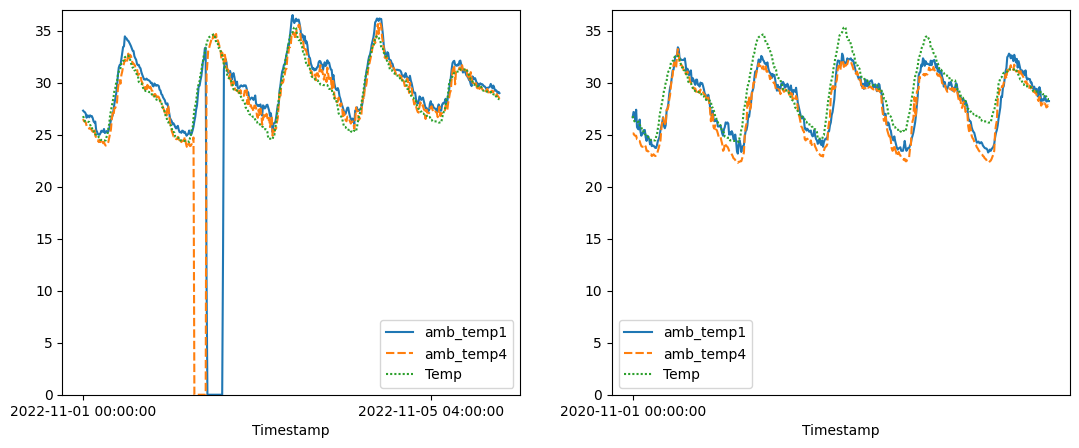

In [ ]:
n=24
d1=t1.copy().loc['2022-11-01 16:45:00':'2022-11-06 16:45:00']
d1['ts']=d1.index
d1.index=pd.to_datetime(d1.index).strftime('%Y-%m-%d')
d1
fig,(ax1,ax2)=plt.subplots(1,2,figsize=[13,5])
sns.lineplot(t1[['amb_temp1','amb_temp4','Temp']].loc['2022-11-01':'2022-11-06'],ax=ax1)
sns.lineplot(t1[['amb_temp1','amb_temp4','Temp']].loc['2020-11-01':'2020-11-06'],ax=ax2)
# ax1.set_xticks([0,400])
ax1.set_ylim([0,37])
ax2.set_ylim([0,37])
ax2.set_xticks([0])
# ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)

# ax1.get_xticklabels()[0].text

# ax2=sns.lineplot(t1[['amb_temp1','amb_temp4','Temp']].loc['2020-11-01 16:45:00':'2020-11-06 16:45:00'])
# ax1.set_xticklabels(ax.get_xticklabels(),rotation=45)

In [ ]:
t1['tempf'].to_pickle('ambtemp.pkl')

In [ ]:
t1[t1.tempf=='dog']

,amb_temp1,amb_temp4,Temp,tempf
Timestamp,,,,
